<a href="https://colab.research.google.com/github/S-Ahsan-Haider/Case-Studies/blob/main/Case_Study_Scaler_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statement:**

**Develop a good understanding of Scaler learners and companies (EDA):**
Using analysisi to identify key characteristics and patterns in the data and using those gain insights into their behaviour and growth.

**Profile the best companies and job positions (Manual Flags):**
Finding the companies and job roles that are most attractive and successful for the learners and also find the factors that contribute to career success within the companies and roles.

**Cluster learners based on similar characteristics (Clustering)**
Group learners with similar job profiles, company preferences, and other relevant features and also do th esame for the companies.

**Provide recommendable insights for all the results that are coming from the above analysis**

**Data Loading**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as s
import io
pd.set_option('display.max_columns', 50)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving scaler_clustering.csv to scaler_clustering.csv


In [ ]:
data = pd.read_csv(io.BytesIO(uploaded['scaler_clustering.csv']))

In [ ]:
df = data.copy()
print('\n', "Column Names:", df.columns,'\n', df.shape,'\n', df.info(), '\n')

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        205843 non-null  int64  
 1   company_hash      205799 non-null  object 
 2   email_hash        205843 non-null  object 
 3   orgyear           205757 non-null  float64
 4   ctc               205843 non-null  int64  
 5   job_position      153279 non-null  object 
 6   ctc_updated_year  205843 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 11.0+ MB

 Column Names: Index(['Unnamed: 0', 'company_hash', 'email_hash', 'orgyear', 'ctc',
       'job_position', 'ctc_updated_year'],
      dtype='object') 
 (205843, 7) 
 None 



,Unnamed: 0,orgyear,ctc,ctc_updated_year
count,205843.000000,205757.000000,2.058430e+05,205843.000000
mean,103273.941786,2014.882750,2.271685e+06,2019.628231
std,59741.306484,63.571115,1.180091e+07,1.325104
min,0.000000,0.000000,2.000000e+00,2015.000000
25%,51518.500000,2013.000000,5.300000e+05,2019.000000
50%,103151.000000,2016.000000,9.500000e+05,2020.000000
75%,154992.500000,2018.000000,1.700000e+06,2021.000000
max,206922.000000,20165.000000,1.000150e+09,2021.000000


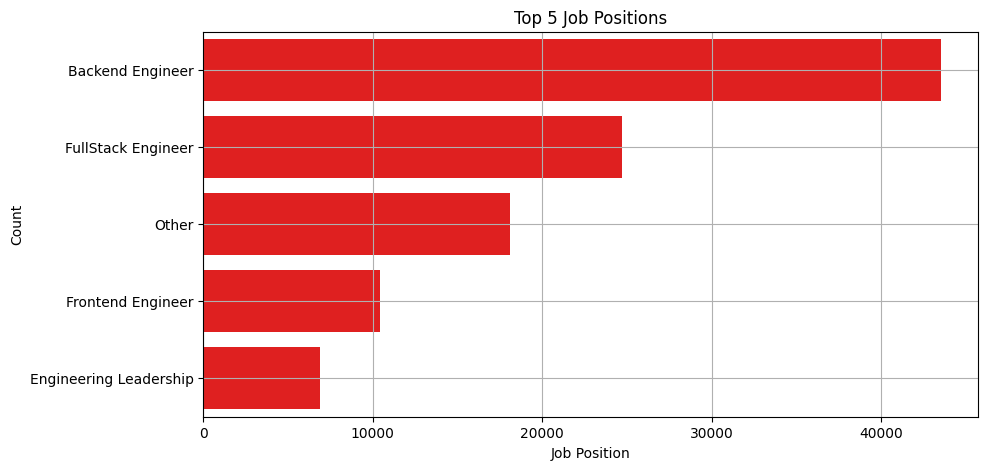

In [ ]:
plt.figure(figsize=(10,5))

sns.barplot(y=df['job_position'].value_counts().head(5).index, x = df['job_position'].value_counts().head(5), color = 'red')

plt.xlabel('Job Position')
plt.ylabel('Count')
plt.title('Top 5 Job Positions')
plt.xticks(rotation=0)

plt.grid("--")
plt.show()

**Data Cleaning**

In [ ]:
df['ctc_updated_year'] = pd.to_numeric(df['ctc_updated_year'], errors='coerce')
df['orgyear'] = pd.to_numeric(df['orgyear'], errors='coerce')

df['ctc_updated_year'] = df['ctc_updated_year'].apply(np.floor)
df['orgyear'] = df['orgyear'].apply(np.floor)

df = df.drop('Unnamed: 0', axis=1)

In [ ]:
print(f'No. of duplicated rows are: {df.duplicated().sum()} \n \n')
df = df.drop_duplicates()

print(f'No. of Null Rows before Imputation (%):\n')
print(((df.isnull().sum()/len(df))*100).sort_values(ascending=False))

No. of duplicated rows are: 34 
 

No. of Null Rows before Imputation (%):

job_position        25.532411
orgyear              0.041786
company_hash         0.021379
email_hash           0.000000
ctc                  0.000000
ctc_updated_year     0.000000
dtype: float64


Example of filling the categorical Column of "job_position"

In [ ]:
df2 = df.copy()

def fill_job_position_mode(df):
    mode_series = df.groupby('company_hash')['job_position'].transform(lambda x: x.mode().iloc[0] if not(x.mode().empty) else 'Other')
    df['job_position'] = df['job_position'].fillna(mode_series)
    return df

df2 = fill_job_position_mode(df2)

print(f'No. of Null Rows after Cleaning job_position column (%):\n')
print(((df2.isnull().sum()/len(df2))*100).sort_values(ascending=False))

df2.head(4)

No. of Null Rows after Cleaning job_position column (%):

company_hash        0.0
email_hash          0.0
orgyear             0.0
ctc                 0.0
job_position        0.0
ctc_updated_year    0.0
dtype: float64


,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,Other,2020.0
1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,FullStack Engineer,2019.0
2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,Backend Engineer,2020.0
3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,Backend Engineer,2019.0


Example of filling null values using KNN Imputations

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

df2 = df[['orgyear','ctc','ctc_updated_year']].copy()

print(f'No. of Null Rows before Cleaning using KNN Imputations (%):\n')
print(((df2.isnull().sum()/len(df2))*100).sort_values(ascending=False))

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=5))
])

d2 = pipeline.fit_transform(df2)
df2 = pd.DataFrame(d2, columns=df2.columns)

print()
print(f'No. of Null Rows after Cleaning using KNN Imputations (%):\n')
print(((df2.isnull().sum()/len(df2))*100).sort_values(ascending=False))

No. of Null Rows before Cleaning using KNN Imputations (%):

orgyear             0.041786
ctc                 0.000000
ctc_updated_year    0.000000
dtype: float64

No. of Null Rows after Cleaning using KNN Imputations (%):

orgyear             0.0
ctc                 0.0
ctc_updated_year    0.0
dtype: float64


In [ ]:
df = df.dropna()
print(f'No. of Null Rows After Deletion:\n')
print(((df.isnull().sum()/len(df))*100).sort_values(ascending=False))

No. of Null Rows After Deletion:

Unnamed: 0          0.0
company_hash        0.0
email_hash          0.0
orgyear             0.0
ctc                 0.0
job_position        0.0
ctc_updated_year    0.0
dtype: float64


<ipython-input-14-eff695356778>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
<ipython-input-14-eff695356778>:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


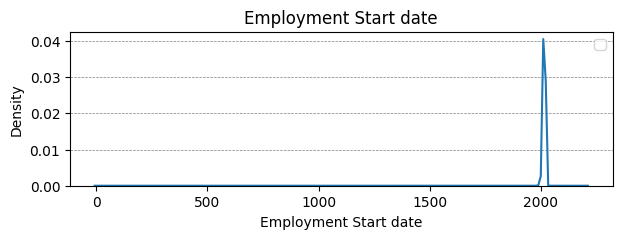

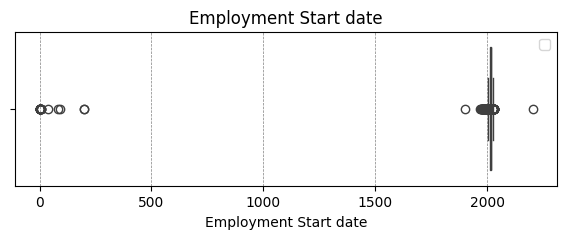

<ipython-input-14-eff695356778>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
<ipython-input-14-eff695356778>:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


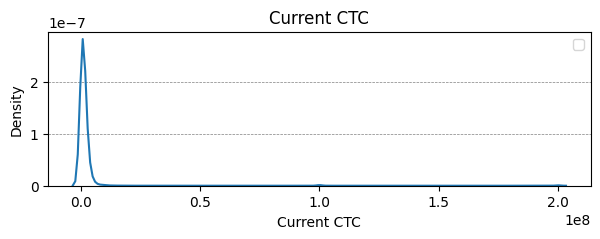

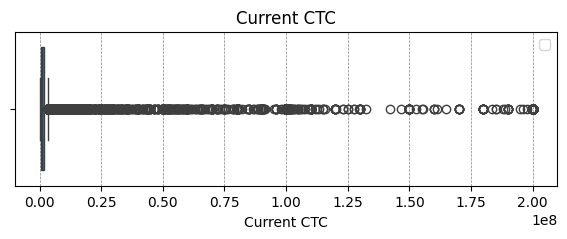

<ipython-input-14-eff695356778>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
<ipython-input-14-eff695356778>:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


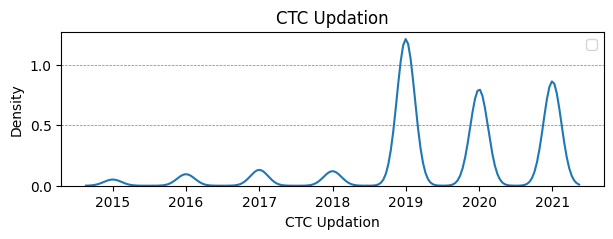

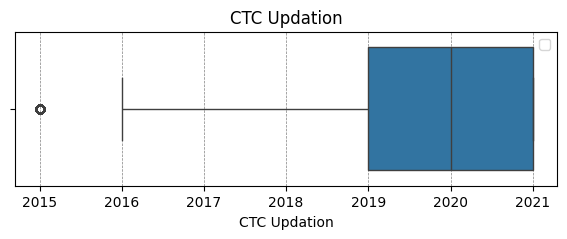

In [ ]:
def univariate(df, column_name, title):

  plt.figure(figsize=(7, 2))
  sns.kdeplot(df[column_name])
  plt.title(title)
  plt.xlabel(title)
  plt.ylabel('Density')
  plt.legend()
  plt.grid(True, linestyle='--', linewidth=0.5, color='gray', which='both', axis='y')
  plt.xticks(rotation=0)

  plt.figure(figsize=(7, 2))
  sns.boxplot(x = df[column_name])
  plt.title(title)
  plt.xlabel(title)
  plt.legend()
  plt.grid(True, linestyle='--', linewidth=0.5, color='gray', which='both', axis='x')
  plt.xticks(rotation=0)
  plt.show()


univariate(df, 'orgyear', 'Employment Start date')
univariate(df, 'ctc', 'Current CTC')
univariate(df, 'ctc_updated_year', 'CTC Updation')

In [ ]:
# IQR Method for Years -------------------------------------------------------------------


def outliers(df, col, max_outliers=1000):

  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  lb = Q1 - (1.5 * IQR)
  ub = Q3 + (1.5 * IQR)

  n = sum((df[col] < lb) | (df[col] > ub))
  print(f'No. of rows that would get deleted from {col} are: {n}')
  print(f'Max outlier limit given is: {max_outliers}')

  if n <= max_outliers:

    filtered_df = df.loc[(df[col] >= lb) & (df[col] <= ub)]
    print(f"Removed {n} outliers from '{col}'.")
    return filtered_df
  else:

    print(f"Skipped outlier removal for '{col}'")
    return df.copy()

df = outliers(df, 'orgyear', 10000)
print()
df = outliers(df, 'ctc', 10000)
print()
df = outliers(df, 'ctc_updated_year', 10000)
print()

# Z - Score Method for CTC due to flattened curve -------------------------------------

df['z_score'] = (df['ctc'] - df['ctc'].mean()) / df['ctc'].std()

thrs = 3

print('Outliers of column ctc has been removed taking threshold as:', thrs)
print()

df = df[df['z_score'].abs() <= thrs]

df = df.drop('z_score', axis=1)


No. of rows that would get deleted from orgyear are: 7764
Max outlier limit given is: 10000
Removed 7764 outliers from 'orgyear'.

No. of rows that would get deleted from ctc are: 12357
Max outlier limit given is: 10000
Skipped outlier removal for 'ctc'

No. of rows that would get deleted from ctc_updated_year are: 2865
Max outlier limit given is: 10000
Removed 2865 outliers from 'ctc_updated_year'.

Outliers of column ctc has been removed taking threshold as: 3



In [ ]:
df['year_joined'] = pd.to_datetime(df['orgyear'], format='%Y').dt.year

df['year_updated'] = pd.to_datetime(df['ctc_updated_year'], format='%Y').dt.year

# Makes no sense that in so many rows, date of joining comes after date of CTC update (must be flipped during data entry)

def flip_dates(row):
    if row['year_joined'] > row['year_updated']:
        row['year_joined'], row['year_updated'] = row['year_updated'], row['year_joined']
    return row

df = df.apply(flip_dates, axis=1)

In [ ]:
df['exp'] = (df['year_updated'] - df['year_joined'])

df = df.drop(['ctc_updated_year', 'orgyear'], axis =1)

In [ ]:
df.head()

,company_hash,email_hash,ctc,job_position,year_joined,year_updated,exp,email
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,1100000,Other,2016,2020,4,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...
1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,449999,FullStack Engineer,2018,2019,1,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...
2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2000000,Backend Engineer,2015,2020,5,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...
3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,700000,Backend Engineer,2017,2019,2,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...
4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,1400000,FullStack Engineer,2017,2019,2,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...


In [ ]:
import re

def clean_email(email):
  return re.sub('[^A-Za-z0-9_.@]+', '', email)

df['email'] = df['email_hash'].apply(clean_email)
df['company'] = df['company_hash'].apply(clean_email)

df = df.drop(['email_hash', 'company_hash'], axis =1)

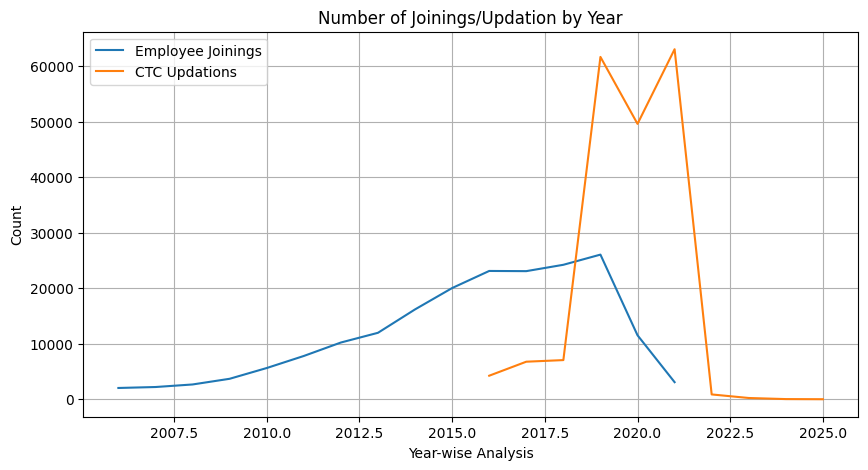

In [ ]:
y1 = df['year_joined'].value_counts().sort_index()
y2 = df['year_updated'].value_counts().sort_index()

plt.figure(figsize=(10,5))

sns.lineplot(x=y1.index, y=y1, label='Employee Joinings')
sns.lineplot(x=y2.index, y=y2, label='CTC Updations')

plt.xlabel('Year-wise Analysis')
plt.ylabel('Count')
plt.title('Number of Joinings/Updation by Year')
plt.xticks(rotation=0)

plt.grid("--")
plt.legend()
plt.show()

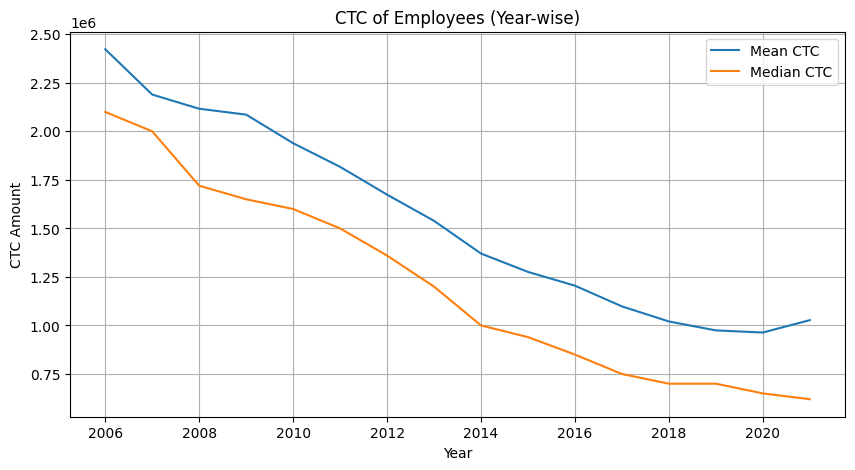

In [ ]:
y1 = df.groupby('year_joined')['ctc'].mean().sort_index()
y2 = df.groupby('year_joined')['ctc'].median().sort_index()

plt.figure(figsize=(10,5))

sns.lineplot(x=y1.index, y=y1, label='Mean CTC')
sns.lineplot(x=y1.index, y=y2, label='Median CTC')

plt.xlabel('Year')
plt.ylabel('CTC Amount')
plt.title('CTC of Employees (Year-wise)')
plt.xticks(rotation=0)

plt.grid("--")
plt.legend()
plt.show()

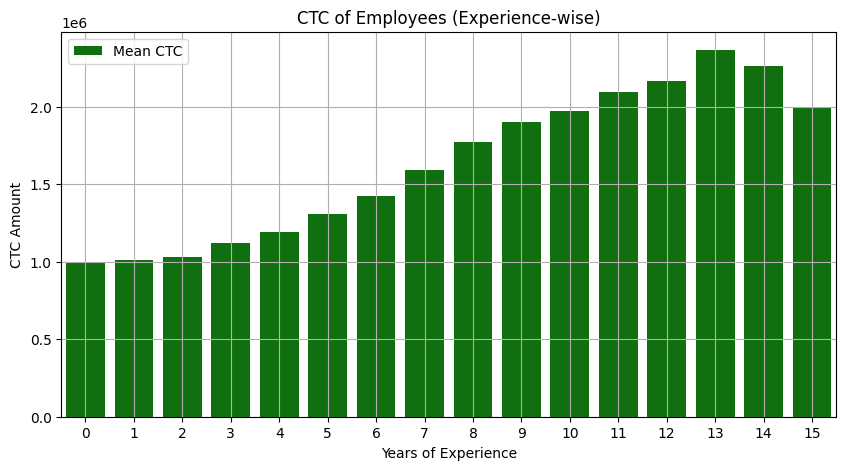

In [ ]:
y1 = df.groupby('exp')['ctc'].mean().sort_index()

plt.figure(figsize=(10,5))

sns.barplot(x=y1.index, y=y1, label='Mean CTC', color='green')

plt.xlabel('Years of Experience')
plt.ylabel('CTC Amount')
plt.title('CTC of Employees (Experience-wise)')
plt.xticks(rotation=0)

plt.grid("--")
plt.legend()
plt.show()

**Manual Clustering**

<ipython-input-39-12c10fc34dec>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts, palette="husl")


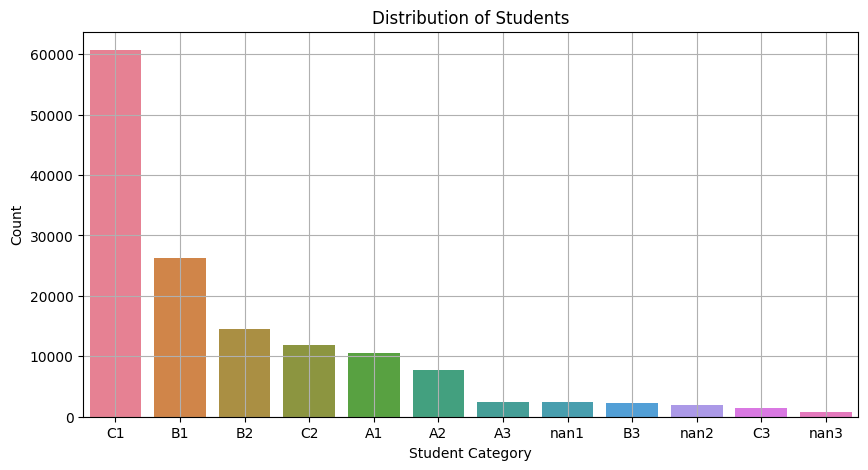

In [ ]:
s = df.groupby('email').agg({'ctc':'max', 'exp':'max', 'company':'count'}).reset_index()

s['exp_rating'] = pd.cut(s['exp'],
                   bins=[0, 6, 11, 16],
                   labels=[1, 2, 3],
                   right=False)

s['exp_rating'] = s['exp_rating'].astype(str)

s['ctc_rating'] = pd.cut(s['ctc'],
                   bins=[0, 1000000, 2000000, 4000000],
                   labels=['C', 'B', 'A'],
                   right=False)
s['ctc_rating'] = s['ctc_rating'].astype(str)

s['stud_rating'] = s['ctc_rating'] + s['exp_rating']

category_counts = s['stud_rating'].value_counts()

plt.figure(figsize=(10,5))

sns.barplot(x=category_counts.index, y=category_counts, palette="husl")

plt.xlabel('Student Category')
plt.ylabel('Count')
plt.title('Distribution of Students')

plt.grid("--")
plt.show()

<ipython-input-40-577b1cb9ffc0>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts, palette="husl")


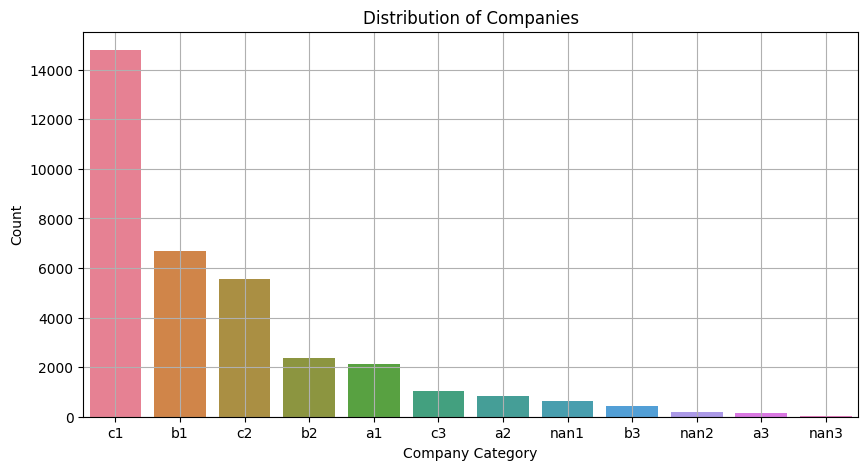

In [ ]:
c = df.groupby('company').agg({'ctc':'mean', 'exp':'mean', 'email':'count'}).reset_index()

c['exp_rating'] = pd.cut(s['exp'],
                   bins=[0, 6, 11, 16],
                   labels=[1, 2, 3],
                   right=False)

c['exp_rating'] = c['exp_rating'].astype(str)



c['ctc_rating'] = pd.cut(c['ctc'],
                   bins=[0, 1000000, 2000000, 4000000],
                   labels=['c', 'b', 'a'],
                   right=False)
c['ctc_rating'] = c['ctc_rating'].astype(str)



c['comp_rating'] = c['ctc_rating'] + c['exp_rating']

category_counts = c['comp_rating'].value_counts()

plt.figure(figsize=(10,5))

sns.barplot(x=category_counts.index, y=category_counts, palette="husl")

plt.xlabel('Company Category')
plt.ylabel('Count')
plt.title('Distribution of Companies')

plt.grid("--")
plt.show()

**Company Flags**

In [ ]:
c_database = df.groupby('company').agg({'ctc':'mean',
                                       'exp':'mean',
                                       'email':'nunique',
                                       'year_joined':['nunique', 'last']}).reset_index()

c_database.columns = ['company', 'mean_ctc', 'mean_exp',
                      'unique_emails', 'no_of_hiring_years', 'last_hired_in']

c_database['hire_per_year'] = c_database['unique_emails'] / c_database['no_of_hiring_years']

c_database = c_database.rename(columns={'exp': 'promotions', 'email':'hirings'})

c_database.head(3)

,company,mean_ctc,mean_exp,unique_emails,no_of_hiring_years,last_hired_in,hire_per_year
0,0,1.666667e+05,1.0,2,2,2017,1.0
1,01 ojztqsj,5.500000e+05,5.5,2,2,2016,1.0
2,05mz exzytvrny uqxcvnt rxbxnta,1.100000e+06,2.0,1,1,2019,1.0


In [ ]:
c_database['last_hired_in'].min(), c_database['last_hired_in'].max()

(2006, 2021)

In [ ]:
# cOMPANY fLAGS

def is_multiyear_recruiter(row):
  if row['no_of_hiring_years'] > 2:
    return 1
  else:
    return 0

c_database['multiyear_recruiter'] = c_database.apply(is_multiyear_recruiter, axis=1)

def is_mass_recruiter(row):
  if row['hire_per_year'] > 3:
    return 1
  else:
    return 0

c_database['mass_recruiter'] = c_database.apply(is_mass_recruiter, axis=1)

def has_stopped_hiring(row):
  if (row['last_hired_in'] < 2017) & row['multiyear_recruiter'] == 1:
    return 1
  else:
    return 0

c_database['has_stopped_hiring'] = c_database.apply(has_stopped_hiring, axis=1)

c_database.head(5)

,company,mean_ctc,mean_exp,unique_emails,no_of_hiring_years,last_hired_in,hire_per_year,multiyear_recruiter,mass_recruiter,has_stopped_hiring
0,0,200000.0,1.5,2,2,2017,1.0,0,0,0
1,01ojztqsj,550000.0,5.5,2,2,2016,1.0,0,0,0
2,05mzexzytvrnyuqxcvntrxbxnta,1100000.0,2.0,1,1,2019,1.0,0,0,0
3,1,250000.0,1.0,1,1,2021,1.0,0,0,0
4,1000uqgltwn,600000.0,1.0,1,1,2019,1.0,0,0,0


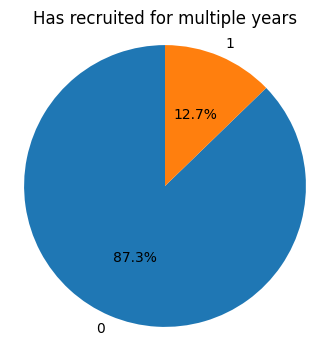

In [ ]:
status_counts = c_database['multiyear_recruiter'].value_counts()

labels = status_counts.index.to_numpy()
sizes = status_counts.to_numpy()

fig1, ax1 = plt.subplots(figsize=(4, 4))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90, pctdistance=0.55, rotatelabels=False)
ax1.set_title('Has recruited for multiple years')

ax1.axis('equal')
plt.show()

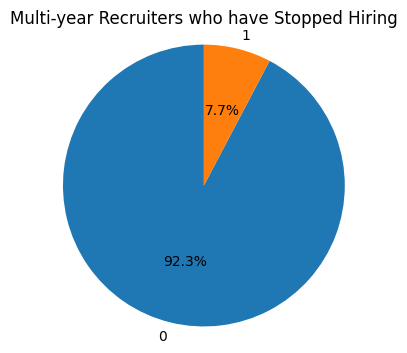

In [ ]:
status_counts = c_database['has_stopped_hiring'].value_counts()

labels = status_counts.index.to_numpy()
sizes = status_counts.to_numpy()

fig1, ax1 = plt.subplots(figsize=(4, 4))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90, pctdistance=0.55, rotatelabels=False)
ax1.set_title('Multi-year Recruiters who have Stopped Hiring')

ax1.axis('equal')
plt.show()

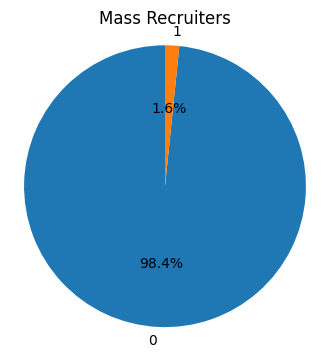

In [ ]:
status_counts = c_database['mass_recruiter'].value_counts()

labels = status_counts.index.to_numpy()
sizes = status_counts.to_numpy()

fig1, ax1 = plt.subplots(figsize=(4, 4))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90, pctdistance=0.55, rotatelabels=False)
ax1.set_title('Mass Recruiters')

ax1.axis('equal')
plt.show()

**Clustering To Create Flags**

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score

In [ ]:
d_num = df.copy()
cols = d_num.columns

d_num['job_position'] = d_num.groupby('job_position')['ctc'].transform('mean')
d_num['company'] = d_num.groupby('company')['ctc'].transform('median')
d_num['email'] = d_num.groupby('email')['exp'].transform('mean')

In [ ]:
# Encoded (Target) for distnace based clustering algos

d_num.head(10)

,ctc,job_position,year_joined,year_updated,exp,email,company,cluster_km,cluster_gmm
0,1100000,1.047865e+06,2016,2020,4,4.0,1070000.0,2,3
1,449999,1.263836e+06,2018,2019,1,1.0,865000.0,0,3
2,2000000,1.519167e+06,2015,2020,5,4.5,2000000.0,2,0
3,700000,1.519167e+06,2017,2019,2,2.0,1350000.0,0,3
4,1400000,1.263836e+06,2017,2019,2,2.0,1000000.0,0,3
5,700000,1.263836e+06,2018,2020,2,2.0,700000.0,0,3
6,1500000,1.263836e+06,2018,2019,1,1.0,1720000.0,0,3
7,400000,1.519167e+06,2019,2019,0,0.0,640000.0,0,3
10,420000,1.263836e+06,2019,2020,1,1.0,595000.0,0,3
11,600000,1.230838e+06,2016,2021,5,4.0,465000.0,2,0


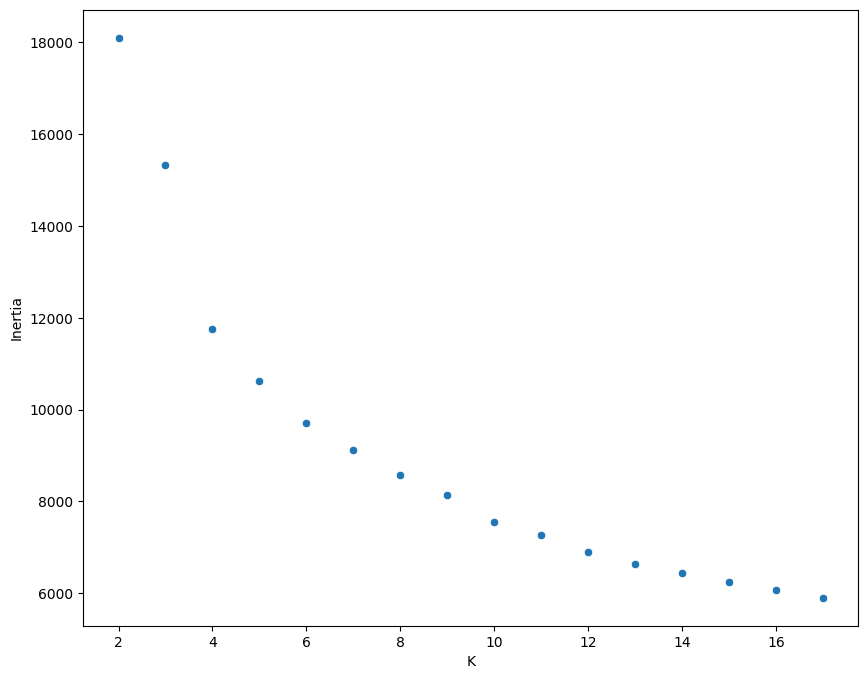

In [ ]:
# K-Means Algorithm

d = d_num.copy()

d = MinMaxScaler().fit_transform(d)
d = pd.DataFrame(d, columns=cols)

Inertia = []
Silhouette = []
Ks = [i for i in range(2,18)]

for i in Ks:
  model = KMeans(n_clusters=i, init="random", n_init=1, algorithm="lloyd", random_state=0)
  model.fit(d)

  iner = model.inertia_
  Inertia.append(iner)


plt.figure(figsize=(10,8))
sns.scatterplot(x=Ks, y=Inertia)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

In [ ]:
d = d_num.copy()
d = MinMaxScaler().fit_transform(d)
d = pd.DataFrame(d, columns=cols)

cluster_best = 4   # From the above graph

best = KMeans(n_clusters = cluster_best, init="random", n_init=1, algorithm="lloyd", random_state=0)
best.fit(d)
y_ = best.fit_predict(d)


df['cluster_km'] = y_

In [ ]:
# GMM Clustering

d = d_num.copy()

d = MinMaxScaler().fit_transform(d)
d = pd.DataFrame(d, columns=cols)

Silhouette = []
Cs = [i for i in range(4,6)]

for i in Cs:
  model = GaussianMixture(n_components=i, random_state=0)
  model.fit(d)
  y_pred = model.predict(d)

  silho = silhouette_score(d, y_pred)

  print(f'Silhouete Score for {i} clusters:', silho)

Silhouete Score for 4 clusters: -0.028296928401896116
Silhouete Score for 5 clusters: 0.021985536201897422


In [ ]:
d = d_num.copy()
d = MinMaxScaler().fit_transform(d)
d = pd.DataFrame(d, columns=cols)

c_best = 5
best = GaussianMixture(n_components=c_best, random_state=0)
best.fit(d)
y_ = best.predict(d)


df['cluster_gmm'] = y_

In [ ]:
# Agglomerative Clustering

d = d_num.copy().head(1000)

d = MinMaxScaler().fit_transform(d)
d = pd.DataFrame(d, columns=cols)

best = AgglomerativeClustering(n_clusters=4, linkage = 'ward')
best.fit(d)
y_ = best.fit_predict(d)


d['cluster_agg'] = y_

Text(0.5, 1.0, '2D tSNE Visualisation')

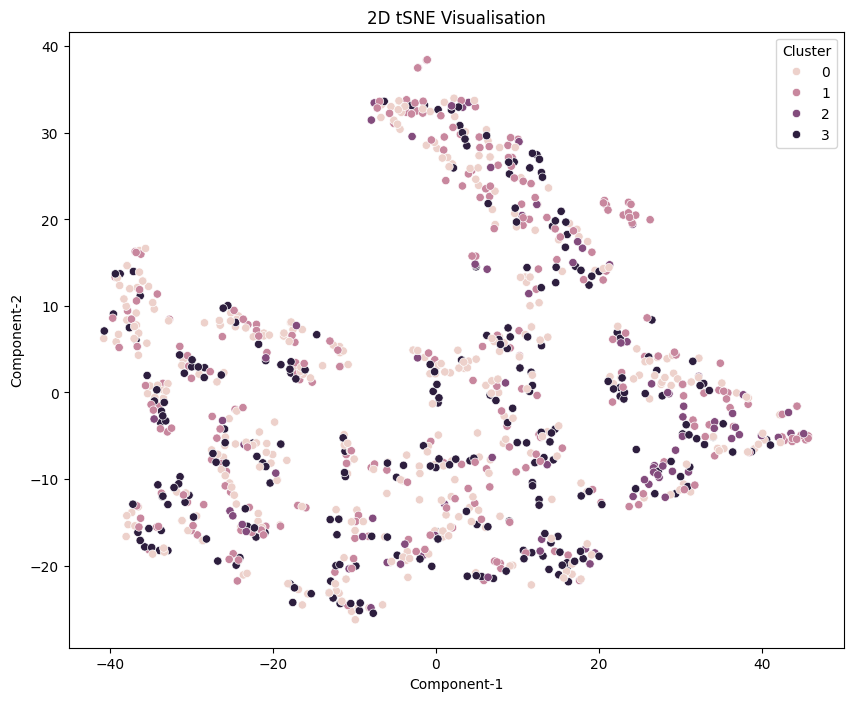

In [ ]:
v = d_num.copy().head(1000)

t = TSNE(2).fit_transform(v)
t = pd.DataFrame(t, columns=['c1', 'c2'])
t['Cluster'] = y_

plt.figure(figsize=(10,8))
sns.scatterplot(x = t['c1'], y = t['c2'], hue = t['Cluster'])
plt.xlabel('Component-1')
plt.ylabel('Component-2')
plt.title('2D tSNE Visualisation')

Text(0, 0.5, 'distance')

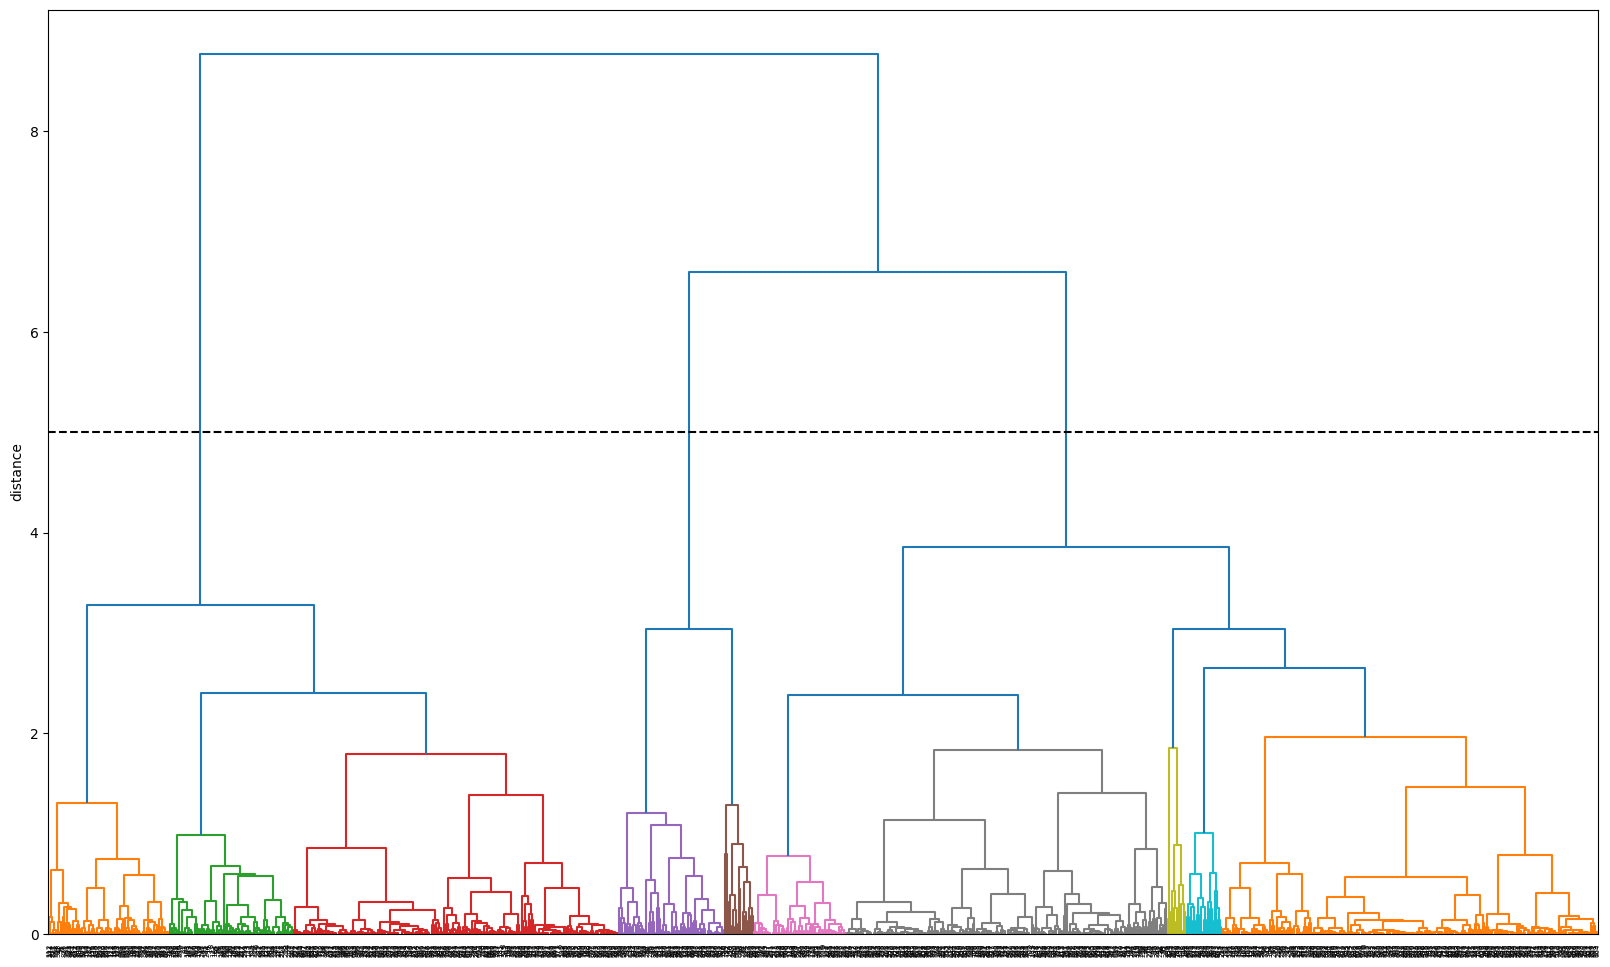

In [ ]:
import scipy.cluster.hierarchy as sch

initial_d = d.drop('cluster_agg', axis=1)

Z = sch.linkage(initial_d, method='ward')

fig, ax = plt.subplots(figsize=(20, 12))
sch.dendrogram(Z, labels=initial_d.index, ax=ax, color_threshold=2)
plt.axhline(y=5, color='k', linestyle='--')
plt.xticks(rotation=90)
ax.set_ylabel('distance')

In [ ]:
# DBSCAN Clustering

initial_d = d.drop('cluster_agg', axis=1)


model = DBSCAN(eps = 1.0, min_samples = 12)
model.fit(initial_d)

y_ = model.fit_predict(initial_d)


d['cluster_dbscan'] = y_

Text(0.5, 1.0, '2D tSNE Visualisation')

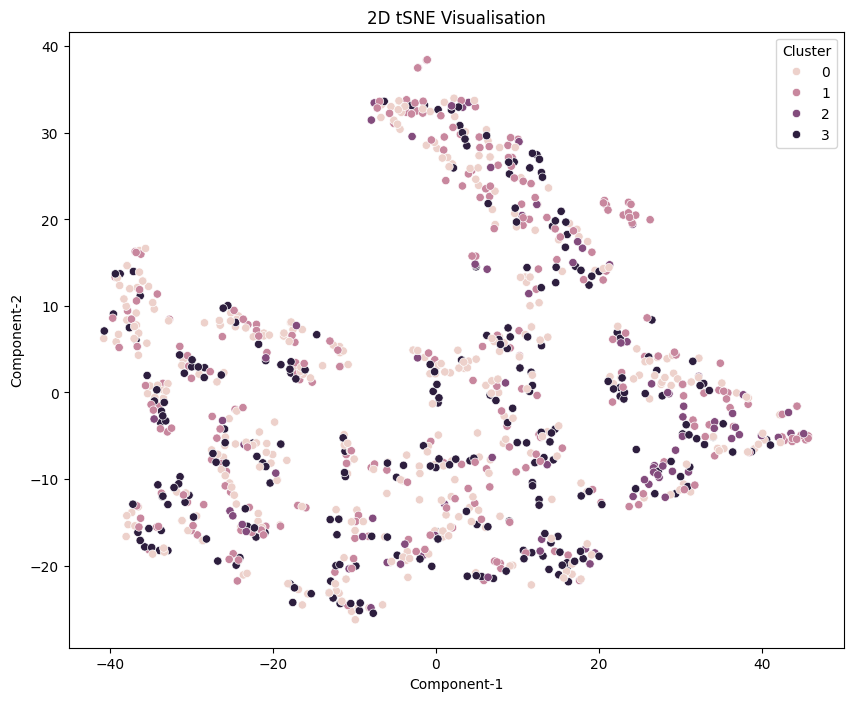

In [ ]:
v = d_num.copy().head(1000)

t = TSNE(2).fit_transform(v)
t = pd.DataFrame(t, columns=['c1', 'c2'])
t['Cluster'] = y_

plt.figure(figsize=(10,8))
sns.scatterplot(x = t['c1'], y = t['c2'], hue = t['Cluster'])
plt.xlabel('Component-1')
plt.ylabel('Component-2')
plt.title('2D tSNE Visualisation')

**Visualisation of Clusters**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143166 entries, 0 to 205329
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   ctc           143166 non-null  int64 
 1   job_position  143166 non-null  object
 2   year_joined   143166 non-null  int64 
 3   year_updated  143166 non-null  int64 
 4   exp           143166 non-null  int64 
 5   email         143166 non-null  object
 6   company       143166 non-null  object
 7   cluster_km    143166 non-null  int32 
 8   cluster_gmm   143166 non-null  int64 
dtypes: int32(1), int64(5), object(3)
memory usage: 10.4+ MB


In [ ]:
df.describe()

,ctc,year_joined,year_updated,exp,cluster_km,cluster_gmm
count,1.431660e+05,143166.000000,143166.000000,143166.000000,143166.000000,143166.000000
mean,1.324565e+06,2015.309445,2019.624995,4.315550,1.132860,2.458887
std,1.543665e+06,3.259654,1.197078,3.085185,1.153645,0.863965
min,2.000000e+00,2006.000000,2016.000000,0.000000,0.000000,0.000000
25%,5.500000e+05,2013.000000,2019.000000,2.000000,0.000000,2.000000
50%,9.300000e+05,2016.000000,2020.000000,4.000000,1.000000,3.000000
75%,1.600000e+06,2018.000000,2021.000000,6.000000,2.000000,3.000000
max,3.760000e+07,2021.000000,2025.000000,15.000000,3.000000,4.000000


In [ ]:
df.columns

Index(['ctc', 'job_position', 'year_joined', 'year_updated', 'exp', 'email',
       'company', 'cluster_km', 'cluster_gmm'],
      dtype='object')

Text(0.5, 1.0, '2D PCA Visualisation')

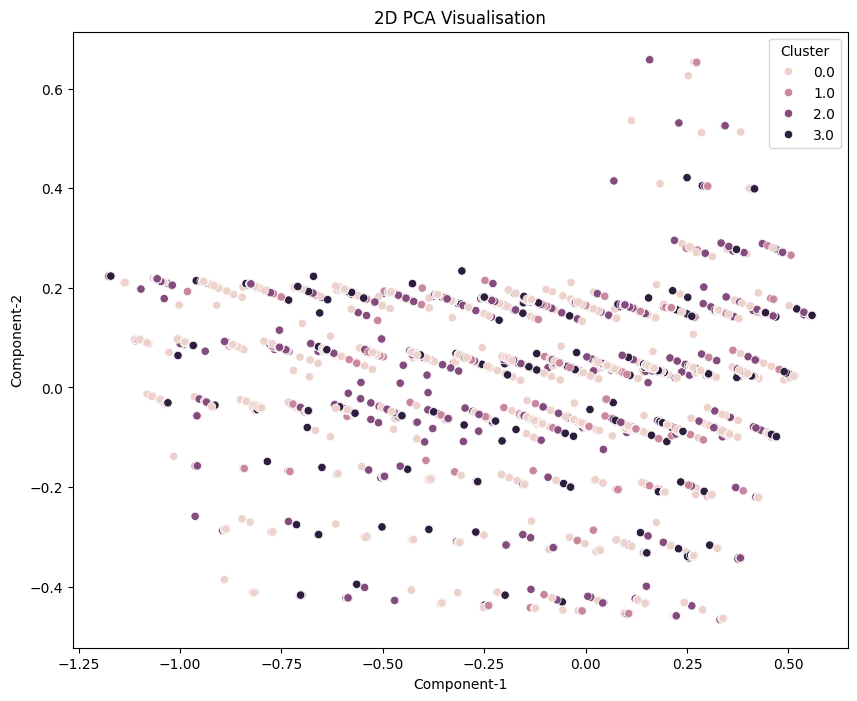

In [ ]:
# Picking Results to diplay

results = 'cluster_km'    # Change to 'cluster_gmm' and 'cluster_agg'

d = d_num.copy()

d = MinMaxScaler().fit_transform(d)
d = pd.DataFrame(d, columns=cols)


p = PCA(2).fit_transform(d)
p = pd.DataFrame(p, columns=['c1', 'c2'])
p['Cluster'] = df[results]

plt.figure(figsize=(10,8))
sns.scatterplot(x = p['c1'], y = p['c2'], hue = p['Cluster'])
plt.xlabel('Component-1')
plt.ylabel('Component-2')
plt.title('2D PCA Visualisation')

**Cluster-Wise Analysis**

In [ ]:
df.columns

Index(['ctc', 'job_position', 'year_joined', 'year_updated', 'exp', 'email',
       'company', 'cluster_km', 'cluster_gmm'],
      dtype='object')

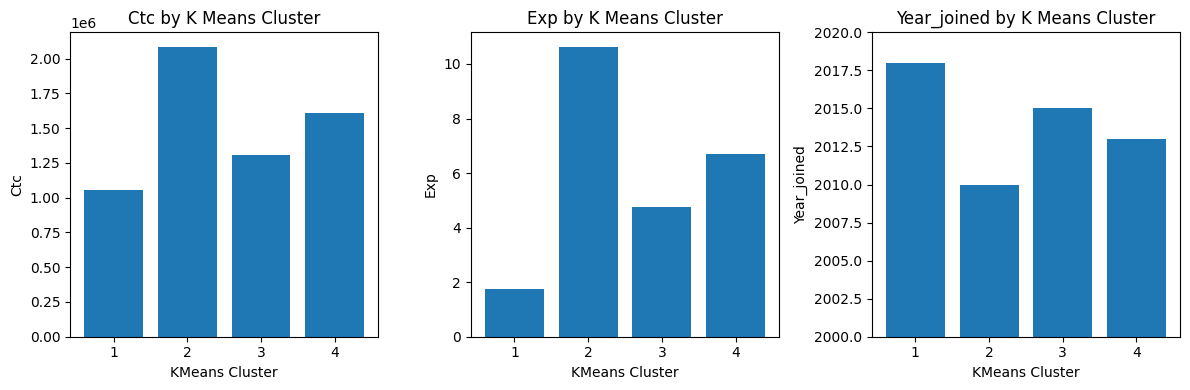

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, (column, ax) in enumerate(zip(['ctc', 'exp', 'year_joined'], axes.flat)):

  if column == 'ctc' or column == 'exp':
    values = df.groupby('cluster_km')[column].mean()
  else:
    values = df.groupby('cluster_km')[column].agg(lambda x: x.value_counts().index[0])


  ax.bar(['1', '2', '3', '4'], values.values)
  ax.set_xlabel("KMeans Cluster")
  ax.set_ylabel(f"{column.capitalize()}")
  ax.set_title(f"{column.capitalize()} by K Means Cluster")


  if column == 'year_joined':
    ax.set_ylim(2000, 2020)


plt.tight_layout()
plt.show()

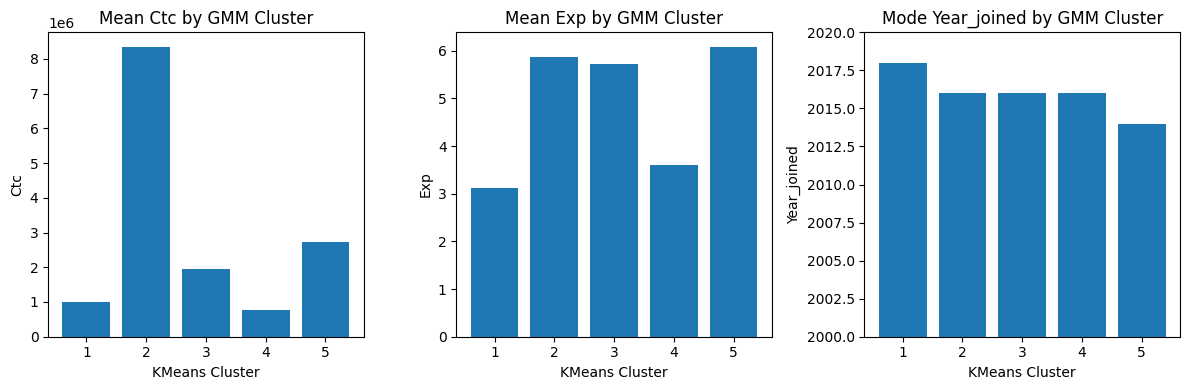

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, (column, ax) in enumerate(zip(['ctc', 'exp', 'year_joined'], axes.flat)):

  if column == 'ctc' or column == 'exp':
    values = df.groupby('cluster_gmm')[column].mean()
  else:
    values = df.groupby('cluster_gmm')[column].agg(lambda x: x.value_counts().index[0])


  ax.bar(['1', '2', '3', '4','5'], values.values)
  ax.set_xlabel("KMeans Cluster")
  ax.set_ylabel(f"{column.capitalize()}")
  ax.set_title(f"Mean {column.capitalize()} by GMM Cluster")


  if column == 'year_joined':
    ax.set_ylim(2000, 2020)
    ax.set_title(f"Mode {column.capitalize()} by GMM Cluster")


plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import plotly.express as px



df_polar = d_vis.groupby('cluster_km').mean().reset_index()

polar = df_polar.melt(id_vars=["cluster_km"], var_name="variable", value_name="value")

polar.head(4)

In [ ]:
fig = px.line_polar(
    polar,
    r="value",
    theta="variable",
    color="cluster_km",
    line_close=True,
    height=700,
    width=800,
)


fig.update_layout(title="Cluster-wise Mean Values")

fig.show()